In [1]:
import modeller
import fitter
import casadi as ca
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# plt.rcParams['figure.figsize'] = [13, 8.]

In [3]:
p_true = [2, 0.75]
tspan = [0, 20]
def system(t, y, p):
    return [
        -p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]),
        p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]) - p[1]*y[1],
        p[1]*y[1]
    ]
sol = solve_ivp(lambda t, y: system(t, y, p_true), tspan, [9999, 1, 0], dense_output=True) 

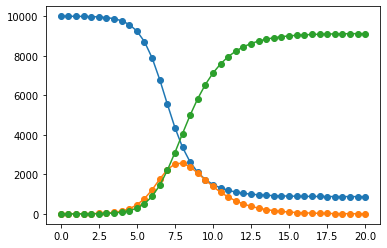

In [4]:
tofsol = np.linspace(0, 20, 41)
plt.figure()
plt.plot(tofsol, sol.sol(tofsol).T, 'o-');

In [5]:
raw_data = sol.sol(tofsol)[2, :]
gendata = sol.sol(tofsol)[1, :]

# # GP 
# randdata = np.random.multivariate_normal(gendata, 8000*np.exp(-1/(2*2**2)*np.abs(tofsol.reshape(1,-1)-tofsol.reshape(-1,1))**2)).reshape(1,-1)
# randdata[randdata < 0] = 0

# Poisson
randdata = np.random.default_rng().poisson(gendata)

# # Negative Binomial
# vdisp = 10**2
# randdata = np.random.default_rng().negative_binomial(n=gendata/(vdisp*(1-1/vdisp)), p=1/vdisp)

data = (np.cumsum(randdata)*p_true[1]*np.gradient(tofsol)).reshape(1, -1)

# randdata = gendata
# data = raw_data.reshape(1,-1)

data_pd = np.array([i for i in data.T])

<IPython.core.display.Javascript object>


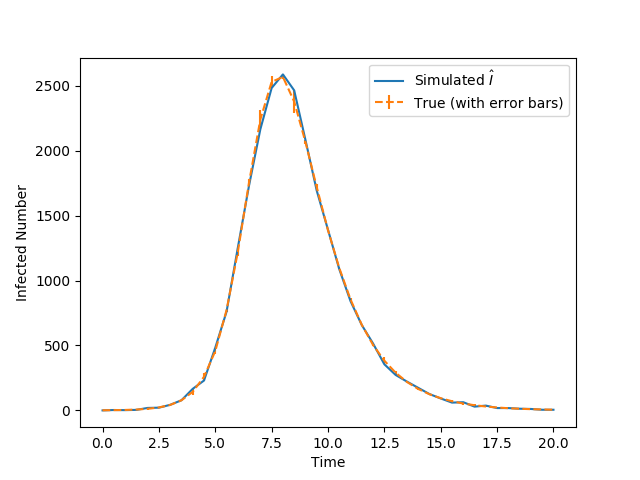

In [53]:
# plt.plot(tofsol, gendata.T)
plt.figure()
plt.plot(tofsol, randdata.T)
plt.errorbar(tofsol, gendata.T, (randdata-gendata).flatten(), linestyle='--')
plt.xlabel('Time')
plt.ylabel("Infected Number")
plt.legend([r'Simulated $\hat{I}$', 'True (with error bars)'])

<IPython.core.display.Javascript object>


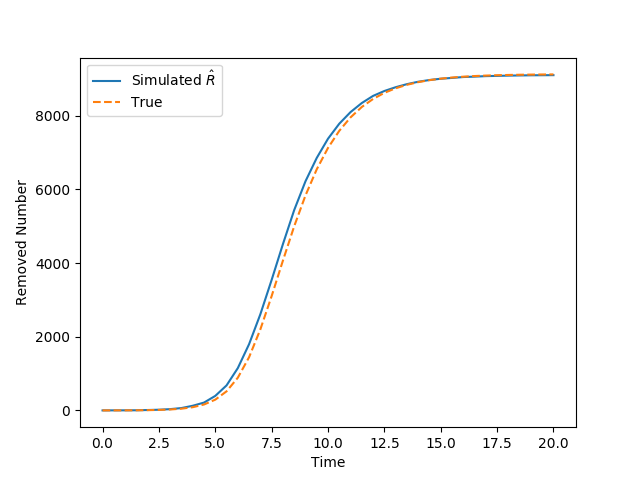

In [54]:
plt.figure()
plt.plot(tofsol, data.T)
plt.plot(tofsol, raw_data.T, '--')
plt.xlabel('Time')
plt.ylabel("Removed Number")
plt.legend([r"Simulated $\hat{R}$", "True"])

In [8]:
def build_config(t,y):
    return {
    "grid_size": 120,
    "basis_number": 60,
    "model_form": {
        "state": 3,
        "parameters": 2
    },
    "time_span": tspan,
    "knot_function": None,
    "model": system,
    "dataset": {"y": y, "t": t},
    "observation_vector": [2],
    "weightings":[
        [1]*3,
        [1]*len(t)
    ],
    "regularisation_value": [0]*len(p_true),
}

In [32]:
p0 = np.ones(2)
config=build_config([None], [None])
c0 = [c*np.linspace(1, 0, config['basis_number'])+d 
      for c,d in zip([10000, 1, -10000], [0, 0, 10000])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*3) + [0]*len(config['regularisation_value'])

testn = 5
# js = list(range(0,len(tofsol),int(len(tofsol)//(testn+1))))[1:-1]
js = [10,11,12,13,14,15,16,17,18,19,20]

fcv_vals = []
fsex = []

for j in js:
    print(f"Running time {j}")
    times_slice = tofsol[0:j]
    data_pd_slice = data_pd[0:j]
    config = build_config(times_slice, data_pd_slice)
    model = modeller.Model(config)
    objective = fitter.Objective()
    objective.make(config, config['dataset'], model)

    solver_setup = {
        'f': objective.objective,
        'x': ca.vcat(objective.input_list),
        'p': ca.hcat([objective.rho, objective.alpha]),
        'g': ca.vcat(model.xs),
    }

    ipopt_opts = {
    'ipopt': {
        'print_level': 3,
        'print_frequency_iter': 20,
        
        }
    }
    
    f1ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
    f2ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
    fsex.append((f1ex, f2ex))

    solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)
    x0 = np.hstack([*c0, p0])
    pure_data = solver(x0=x0, p=[1e-14, 1e-14], lbx=lbx, lbg=0);
    x0 = list(np.array(pure_data['x'][:-2]).flatten()) + list(p0)
    prange = np.logspace(-6, 6, num=50)
    solutions = []
    fcv_vals.append(solutions)
    xguess = x0
    for p in prange:
        print(f"Solving p={p}")
        solutions.append(solver(x0=xguess, p=[p, 0.5], lbx=lbx, lbg=0))
        xguess = np.array(solutions[-1]['x']).flatten()

Running time 10
Running time 11
Running time 12
Running time 13
Running time 14
Running time 15
Running time 16
Running time 17
Running time 18
Running time 19
Running time 20


In [10]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getp', [solver_setup['x']], model.ps)

In [11]:
%matplotlib notebook

<IPython.core.display.Javascript object>


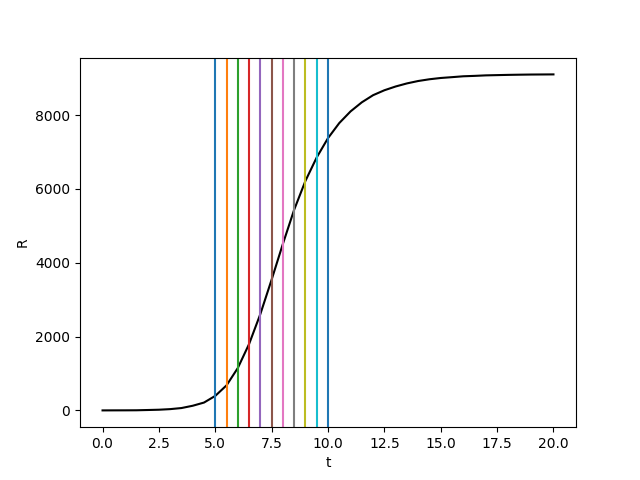

Text(0, 0.5, 'R')

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(tofsol, data_pd.flatten(), color='k')
for j in js:
    plt.axvline(tofsol[j], color=next(ax._get_lines.prop_cycler)['color'])
plt.xlabel("t")
plt.ylabel("R")

In [13]:
flat_data = data_pd.flatten()
def compare(sol):
    x = getx(sol['x'])[-1]
    return ca.sqrt(ca.sumsqr(ca.interp1d(model.observation_times, x, tofsol) - raw_data.flatten()))
    

<IPython.core.display.Javascript object>


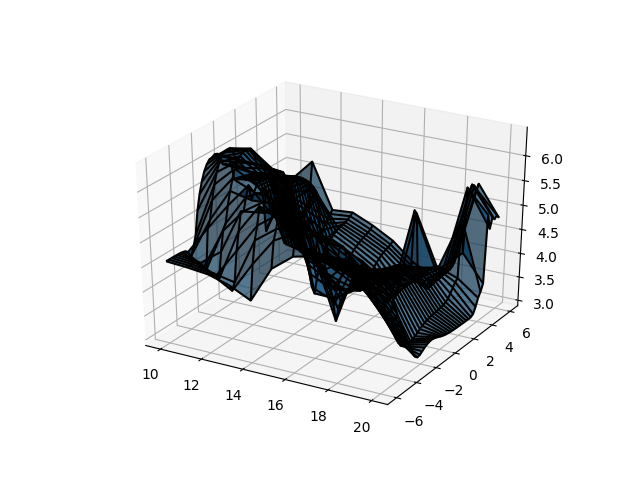

In [55]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x, y = np.meshgrid(js, np.log10(prange))

ax.plot_surface(x.T, y.T, np.log10(np.array([list(map(compare, s)) for s in fcv_vals])), alpha=0.7)
ax.plot_wireframe(x.T, y.T, np.log10(np.array([list(map(compare, s)) for s in fcv_vals])), color='k')

<IPython.core.display.Javascript object>


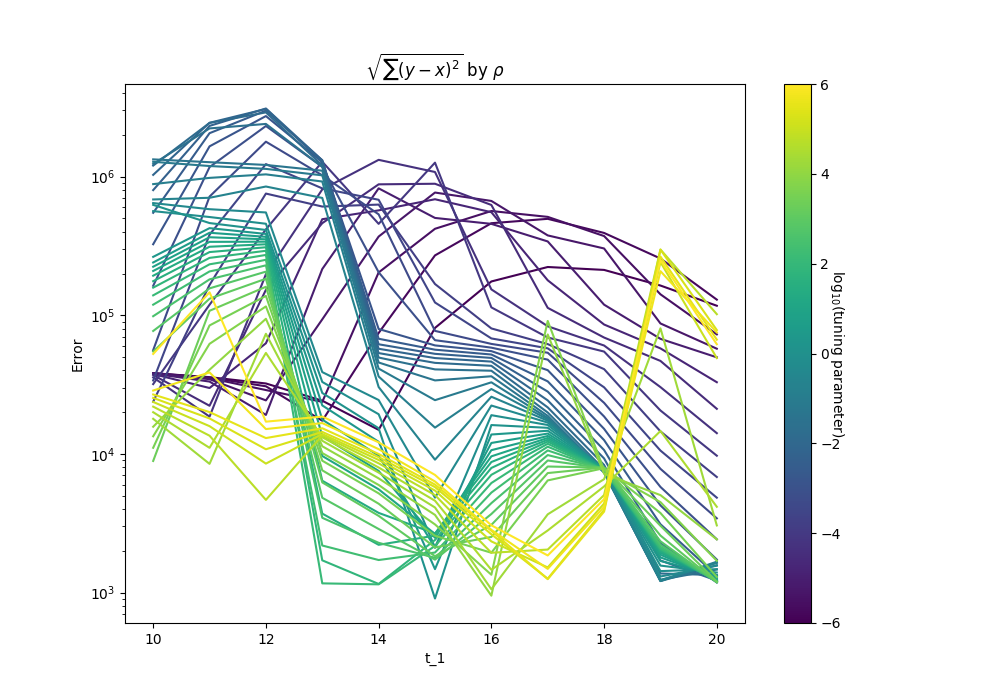

In [15]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

cNorm = colors.Normalize(vmin=np.log10(prange[0]), vmax=np.log10(prange[-1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[10,7])
for i,p in enumerate(prange):
    plt.semilogy(js, list(map(compare, [s[i] for s in fcv_vals])), color=scalarMap.to_rgba(np.log10(p)))
plt.title(r"$\sqrt{\sum (y-x)^2}$ by $\rho$")
plt.xlabel("t_1")
plt.ylabel("Error")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)


<IPython.core.display.Javascript object>


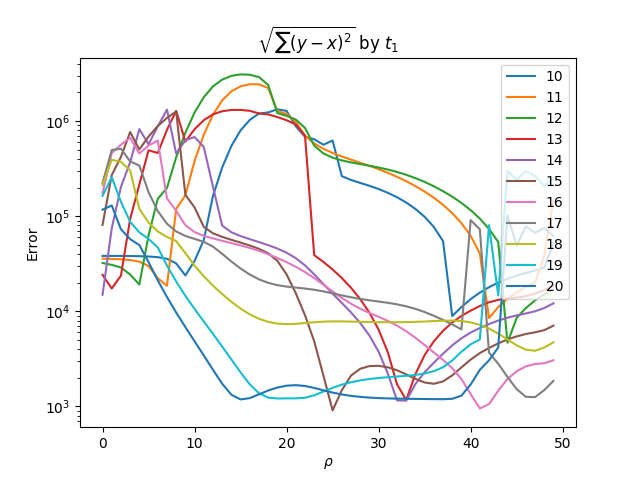

Text(0, 0.5, 'Error')

In [16]:
plt.figure()
for fcv_val in fcv_vals:
    plt.plot(list(map(compare, fcv_val)))
plt.yscale('log')
plt.legend(js)
plt.title(r"$\sqrt{\sum (y-x)^2}$ by $t_1$")
plt.xlabel(r"$\rho$")
plt.ylabel("Error")

<IPython.core.display.Javascript object>


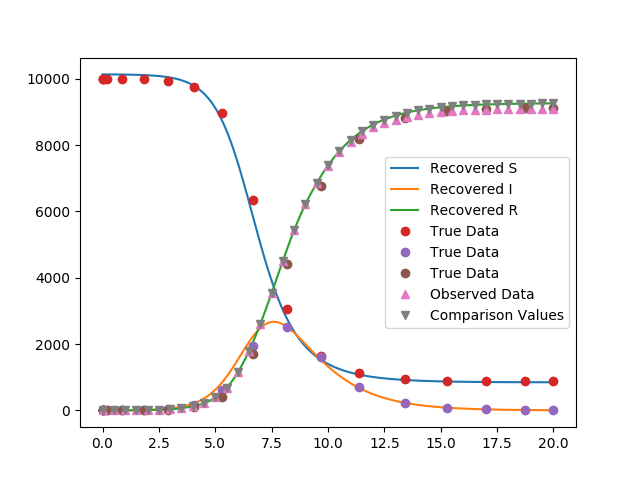

In [30]:
solx = getx(fcv_vals[-1][14]['x'])
plt.figure()
for lbl, xi in zip("SIR", solx):
    plt.plot(model.observation_times, xi, label="Recovered "+lbl)
plt.plot(sol.t, sol.y.T, 'o', label="True Data")
plt.plot(tofsol, data.T, '^', label="Observed Data")
plt.plot(tofsol, ca.interp1d(model.observation_times, solx[-1], tofsol), 'v', label="Comparison Values")
plt.legend(loc='best',)

In [18]:
def x1(sol):
    return np.abs(float(getx(sol['x'])[-1][-1]) - raw_data.flatten()[-1])

<IPython.core.display.Javascript object>


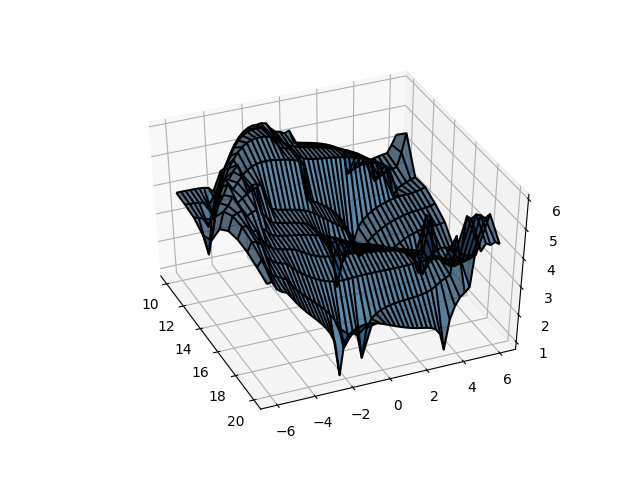

In [51]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x, y = np.meshgrid(js, np.log10(prange))

ax.plot_surface(x.T, y.T, np.log10(np.array([list(map(x1, s)) for s in fcv_vals])), alpha=0.7)
ax.plot_wireframe(x.T, y.T, np.log10(np.array([list(map(x1, s)) for s in fcv_vals])), color='k')

# ax.plot_surface(x.T, y.T, np.log10(np.array([list(map(compare, s)) for s in fcv_vals])), alpha=0.4)
# ax.plot_wireframe(x.T, y.T, np.log10(np.array([list(map(compare, s)) for s in fcv_vals])), color='k')

<IPython.core.display.Javascript object>


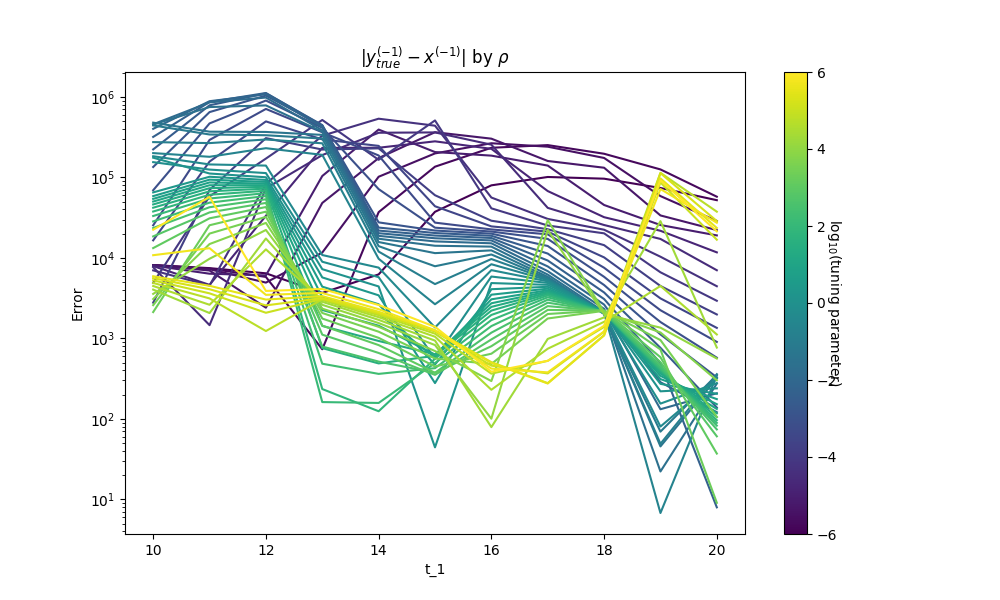

In [20]:
plt.figure(figsize=[10,6])
for i,p in enumerate(prange):
    plt.semilogy(js, list(map(x1, [s[i] for s in fcv_vals])), color=scalarMap.to_rgba(np.log10(p)))
plt.title(r"$|y^{(-1)}_{true}-x^{(-1)}|$ by $\rho$")
plt.xlabel("t_1")
plt.ylabel("Error")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)


<IPython.core.display.Javascript object>


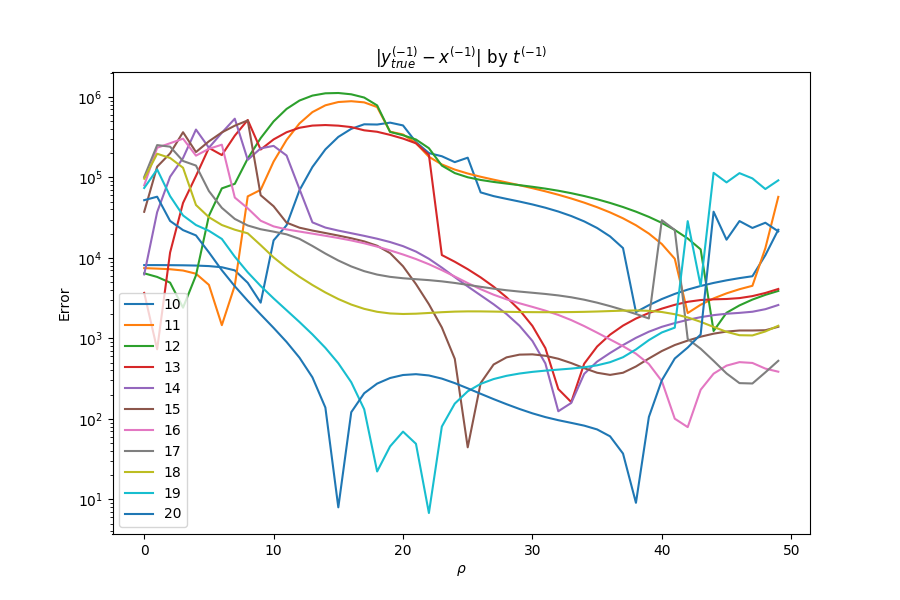

Text(0, 0.5, 'Error')

In [21]:
plt.figure(figsize=[9,6])
for fcv_val in fcv_vals:
    plt.plot(list(map(x1, fcv_val)))
plt.yscale('log')
plt.legend(js)
plt.title(r"$|y^{(-1)}_{true}-x^{(-1)}|$ by $t^{(-1)}$")
plt.xlabel(r"$\rho$")
plt.ylabel("Error")

In [24]:
terpx = [ca.interp1d(model.observation_times, sx, tofsol) for sx in solx]

In [25]:
ca.sumsqr(np.hstack(terpx).T - sol.sol(tofsol))

DM(1.36779e+09)

In [26]:
true_sol = sol.sol(tofsol)
def true_comp(sol):
    terpx = [ca.interp1d(model.observation_times, sx, tofsol) for sx in getx(sol['x'])]
    return ca.sumsqr(np.hstack(terpx).T - true_sol)

<IPython.core.display.Javascript object>


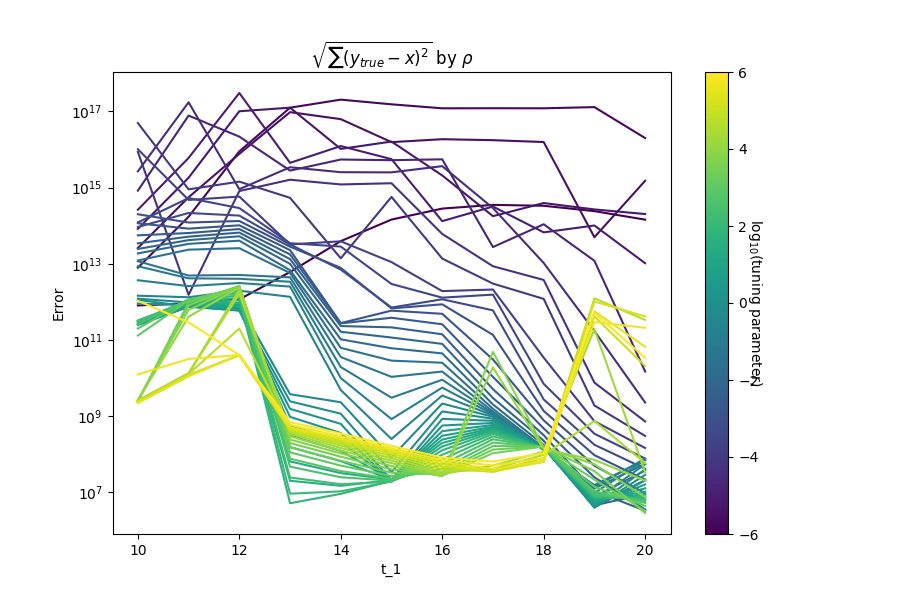

In [27]:
plt.figure(figsize=[9,6])
for i,p in enumerate(prange):
    plt.semilogy(js, list(map(true_comp, [s[i] for s in fcv_vals])), color=scalarMap.to_rgba(np.log10(p)))
plt.title(r"$\sqrt{\sum (y_{true}-x)^2}$ by $\rho$")
plt.xlabel("t_1")
plt.ylabel("Error")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)

<IPython.core.display.Javascript object>


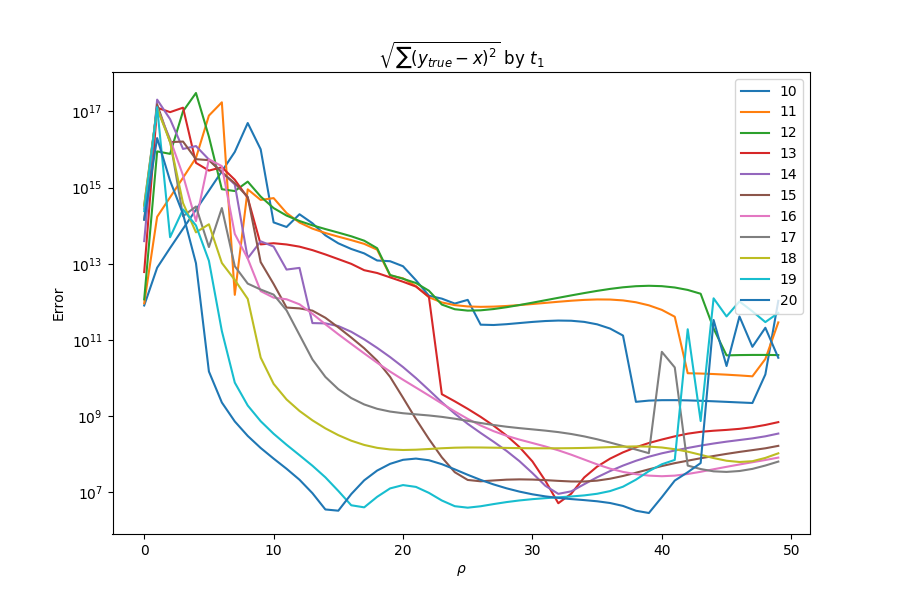

Text(0, 0.5, 'Error')

In [28]:
plt.figure(figsize=[9,6])
for fcv_val in fcv_vals:
    plt.plot(list(map(true_comp, fcv_val)))
plt.yscale('log')
plt.legend(js)
plt.title(r"$\sqrt{\sum (y_{true}-x)^2}$ by $t_1$")
plt.xlabel(r"$\rho$")
plt.ylabel("Error")

<IPython.core.display.Javascript object>


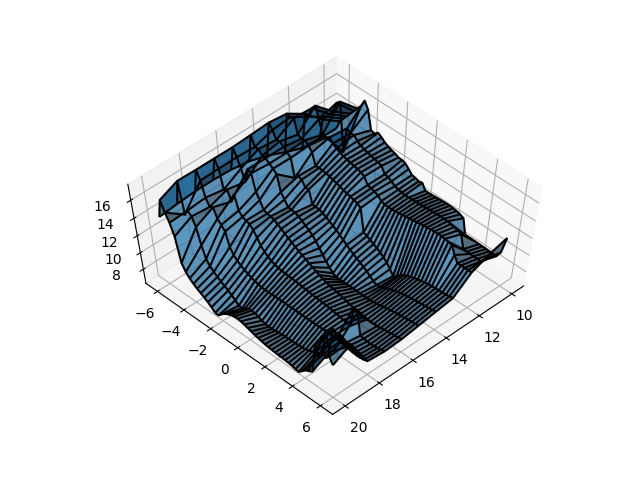

In [52]:
fig = plt.figure()
ax = plt.axes(projection='3d')

x, y = np.meshgrid(js, np.log10(prange))

ax.plot_surface(x.T, y.T, np.log10(np.array([list(map(true_comp, s)) for s in fcv_vals])), alpha=0.7)
ax.plot_wireframe(x.T, y.T, np.log10(np.array([list(map(true_comp, s)) for s in fcv_vals])), color='k')

In [34]:
ldata = []
for (f1_ex, f2_ex), sols in zip(fsex, fcv_vals):
    ldata.append(np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols]))

<IPython.core.display.Javascript object>


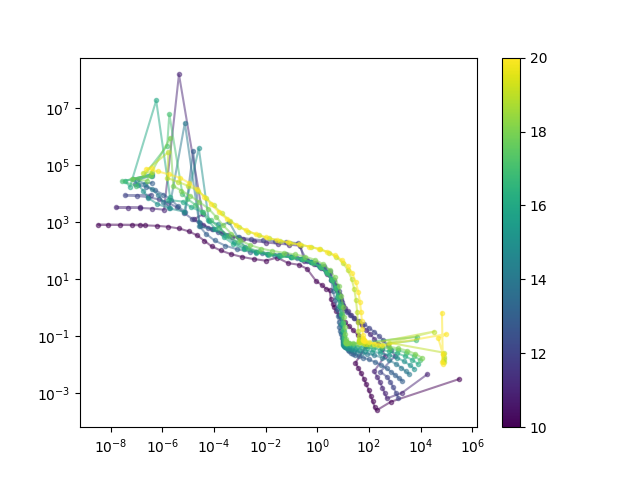

In [50]:
plt.figure()
cNormj = colors.Normalize(vmin=js[0], vmax=js[-1])
cm = plt.get_cmap('viridis')
scalarMapj = mplcm.ScalarMappable(norm=cNormj, cmap=cm)

for j,ld in zip(js,ldata):
    plt.loglog(*ld.T, '.-', color=scalarMapj.to_rgba(j), alpha=0.5)
plt.colorbar(scalarMapj)

<IPython.core.display.Javascript object>


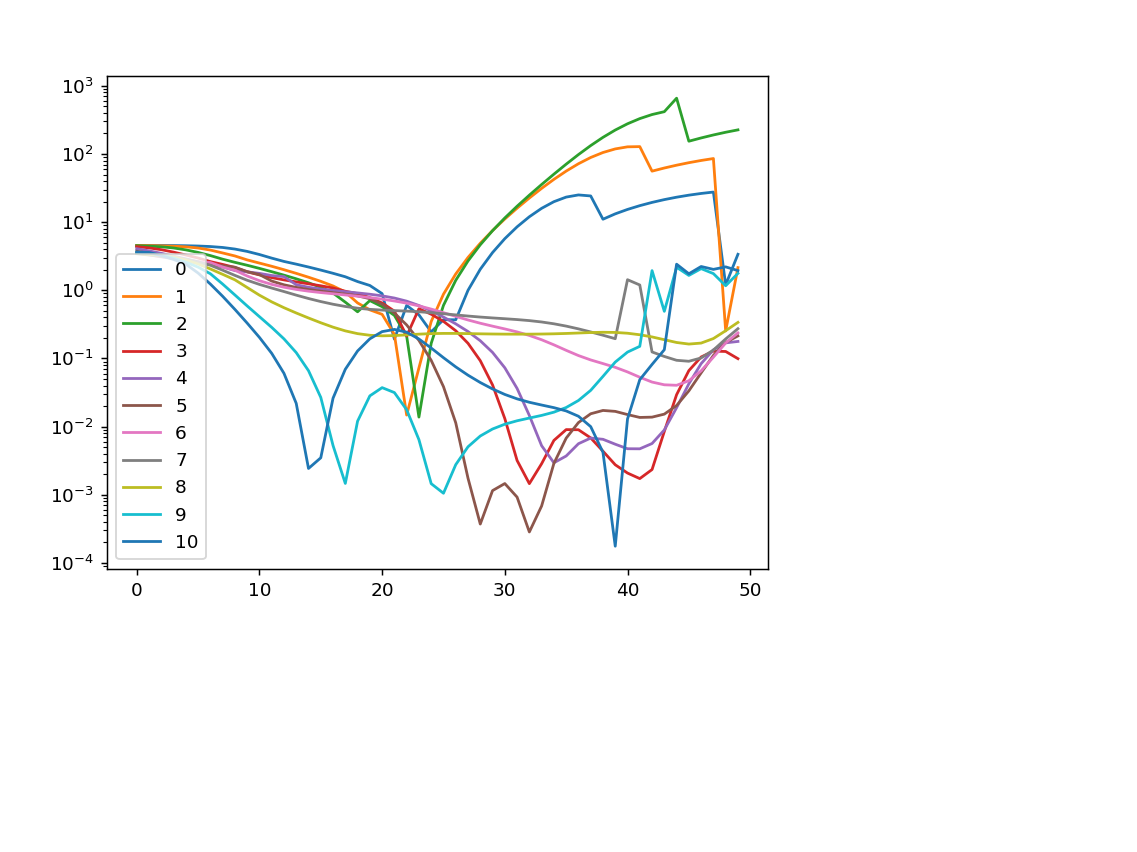

In [60]:
def comp_p(sol):
    return sum((getp(sol['x']) - np.array(p_true))**2)
plt.figure()
for i,fcv_val in enumerate(fcv_vals):
    plt.plot(list(map(comp_p, fcv_val)), label=str(i))
plt.yscale('log')
plt.legend()